# Real data aplication

Import necessary libraries

Tensorflow version 2.15.0 is required to avoid errors

In [ ]:
!pip install tensorflow==2.15.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import joblib
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"Versión de joblib: {joblib.__version__}")

Versión de TensorFlow: 2.15.0
Versión de joblib: 1.4.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "..."

Load models

In [7]:
y_scaler = joblib.load(path + 'y_scaler.pkl')

NN = keras.models.load_model(path + 'model.keras')
NV = keras.models.load_model(path + 'model_vario.keras')

Load data

In [8]:
data = (
    pd.read_csv(path+'aplicacion/sst_full.txt', sep=' ', decimal='.')
    .sort_values(['y', 'x'], ascending=[False, True])
    .reset_index(drop=True)
)
data.head()

x     y             z
0 -179.5  89.5 -2.384186e-07
1 -178.5  89.5 -2.384186e-07
2 -177.5  89.5 -2.384186e-07
3 -176.5  89.5 -2.384186e-07
4 -175.5  89.5 -2.384186e-07

Data figure

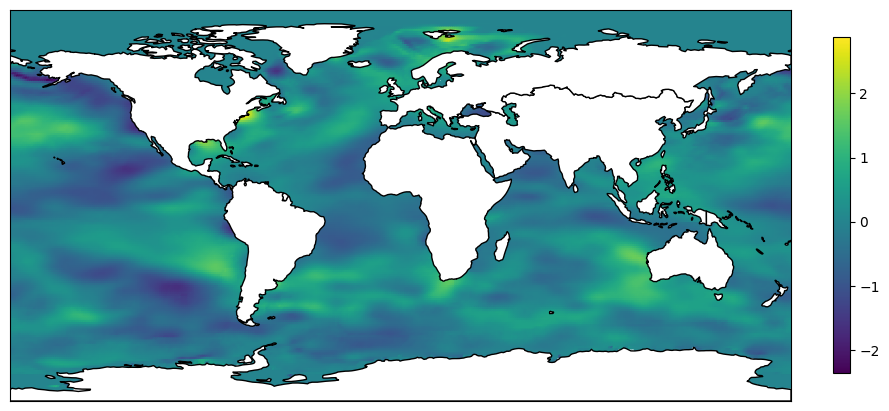

In [9]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).dissolve(by='continent')

fig, ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(data['x'], data['y'], c=data['z'], s=3, cmap='viridis', marker='o')
fig.colorbar(sc, fraction=0.02)
world.plot(ax=ax, color='white', edgecolor='black')
ax.set_xlim(-180, 180); ax.set_ylim(-90, 90)
ax.set_xticks([]); ax.set_yticks([])

fig.tight_layout()
fig.savefig(path+'Figures/sst.png', dpi=150, bbox_inches='tight')
plt.show();

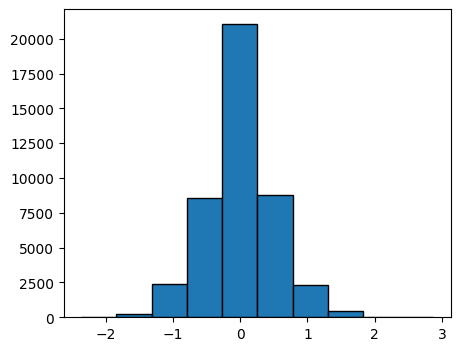

In [10]:
plt.figure(figsize=(5,4))
plt.hist(data['z'], edgecolor='k');

## $16 \times 16$ regions

In [11]:
def plot_ventana(x, y, **kwargs):
    X = [x-8, x+8, x+8, x-8, x-8]
    Y = [y-8, y-8, y+8, y+8, y-8]
    plt.plot(X, Y, '--', **kwargs)

def ventana(x,y):
  return data[(data['x'] >= x-8) & (data['x'] <= x+8) & (data['y'] >= y-8) & (data['y'] <= y+8)].sort_values(['y', 'x'], ascending=[False, True])

In [12]:
x = -150
y = 25
ventana(x,y).shape

(255, 3)

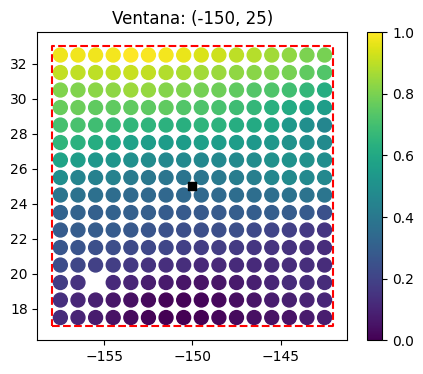

In [13]:
plt.figure(figsize=(5,4))
plt.scatter(ventana(x,y)['x'], ventana(x,y)['y'], c=ventana(x,y)['z'], s=100,
            cmap='viridis', marker='o')
plt.scatter([x], [y], c='k', marker='s')
plot_ventana(x,y, c='r')
plt.title(f'Ventana: ({x}, {y})')
plt.colorbar();

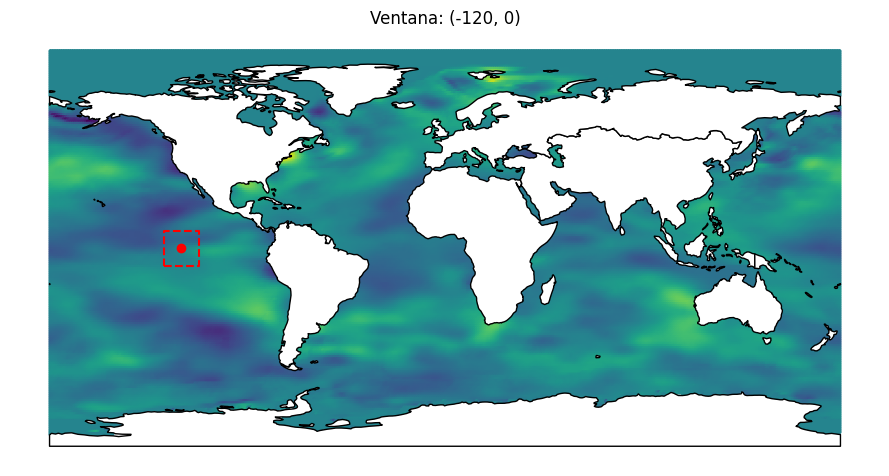

In [14]:
x, y = -120, 0

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(data['x'], data['y'], c=data['z'], s=5, cmap='viridis', marker='o')

ax.scatter([x], [y], c='r', marker='o')
plot_ventana(x,y, c='r', ls='--')

world.plot(ax=ax, color='white', edgecolor='black')
ax.set_axis_off()
plt.title(f'Ventana: ({x}, {y})')
fig.tight_layout()
plt.show()

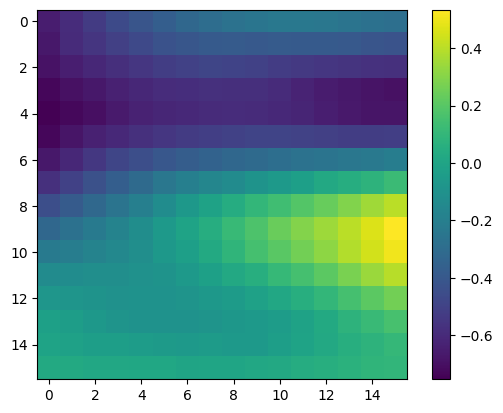

In [15]:
if len(ventana(x,y)) == 256:
  plt.imshow(ventana(x,y)['z'].values.reshape(16,16))
  plt.colorbar();
else:
  print('Faltan puntos.')

## Feasible pixels for region $16\times 16$

In [ ]:
factibles = []
no_factibles = []
for x in range(-172, 172+1):
  for y in range(-75, 75+1):
    aux = ventana(x,y)
    if aux.shape[0] == 256:
      factibles.append((x,y))
    else:
      no_factibles.append((x,y))

In [ ]:
factibles = np.array(factibles)
no_factibles = np.array(no_factibles)

In [ ]:
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

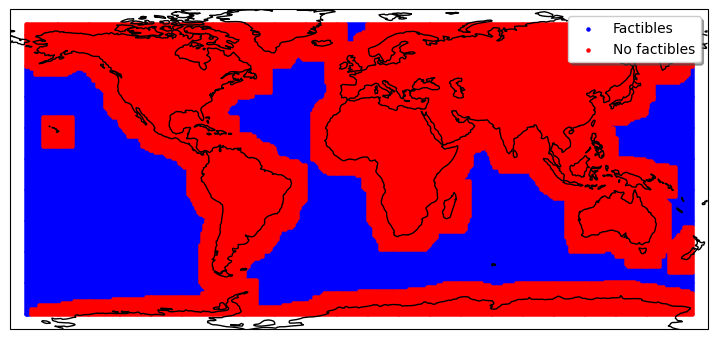

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE)

ax.scatter(factibles[:,0], factibles[:,1], c='b', s=5, label='Factibles')
ax.scatter(no_factibles[:,0], no_factibles[:,1], c='r', s=5, label='No factibles')
plt.legend(shadow=True);

In [ ]:
len(factibles), len(no_factibles)

(19492, 32603)

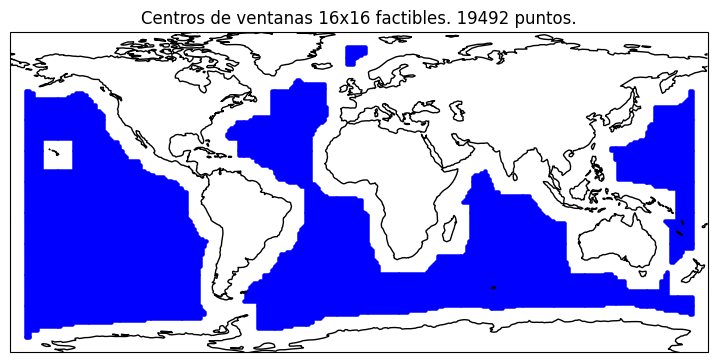

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE)

ax.scatter(factibles[:,0], factibles[:,1], c='b', s=5)
ax.set_title(f'Centros de ventanas 16x16 factibles. {len(factibles)} puntos.');

In [ ]:
fields = []
for x, y in factibles:
    aux = ventana(x,y)

    aux['z'] = (aux['z']-aux['z'].mean())/aux['z'].std()

    fields.append(aux['z'].values.reshape(16,16))

In [ ]:
fields = np.array(fields, dtype=np.float32)

In [ ]:
np.save(path+'aplicacion/fields_sst.npy', fields)

## NF

In [ ]:
fields = np.load(path + 'aplicacion/fields_sst.npy')

In [ ]:
%%time
results = y_scaler.inverse_transform(NN.predict(fields, verbose = 0))

CPU times: user 22.4 s, sys: 286 ms, total: 22.7 s
Wall time: 41.3 s


In [ ]:
df = pd.DataFrame(np.concatenate([factibles, results], axis=1))
df.columns = ['x', 'y', 'alpha', 'theta', 'ratio']
df['Method'] = 'NF'
df.head()

x     y     alpha     theta     ratio Method
0 -172.0 -75.0  1.582205  1.403904  0.091054     NF
1 -172.0 -74.0  1.583251  1.527794  0.098911     NF
2 -172.0 -73.0  1.586350  1.572304  0.106467     NF
3 -172.0 -72.0  1.725402  1.671025  0.121979     NF
4 -172.0 -71.0  1.627009  1.844938  0.137364     NF

In [ ]:
df[(df['alpha']<0) | (df['theta']<0) | (df['ratio']<0)]

x     y     alpha     theta     ratio Method
2677  -148.0 -24.0  1.866006  4.879288 -0.000685     NF
2779  -147.0 -24.0  1.859084  4.902236 -0.003344     NF
2780  -147.0 -23.0  1.893064  4.817174 -0.002228     NF
2897  -146.0 -24.0  1.863010  4.902826 -0.003561     NF
2898  -146.0 -23.0  1.886289  4.845225 -0.002774     NF
...      ...   ...       ...       ...       ...    ...
11613  -17.0 -23.0  1.865361  4.941177 -0.000348     NF
11614  -17.0 -22.0  1.841483  4.921337 -0.000465     NF
11680  -16.0 -23.0  1.833662  4.908466 -0.000972     NF
11681  -16.0 -22.0  1.842310  4.918631 -0.002087     NF
11742  -15.0 -22.0  1.825327  4.917059 -0.002375     NF

[213 rows x 6 columns]

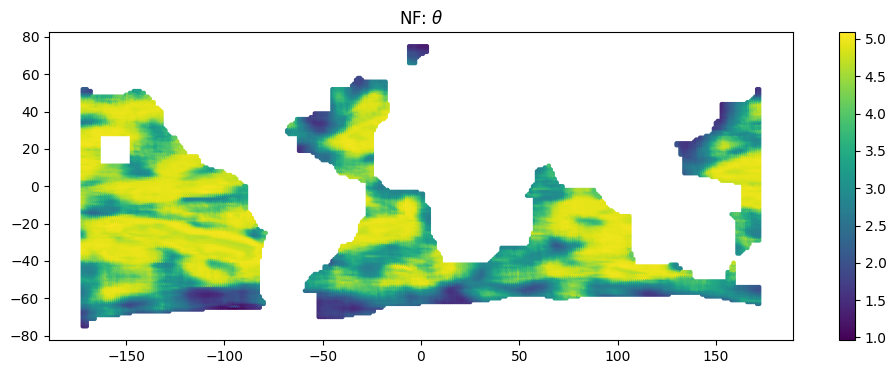

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df['x'], df['y'], c=df['theta'], s=5,
            cmap='viridis', marker='o')
plt.colorbar()

plt.scatter(df[(df['theta']<0)]['x'],
            df[(df['theta']<0)]['y'],
            c='r', s=5, cmap='viridis', marker='o')
plt.title('NF: $\\theta$');

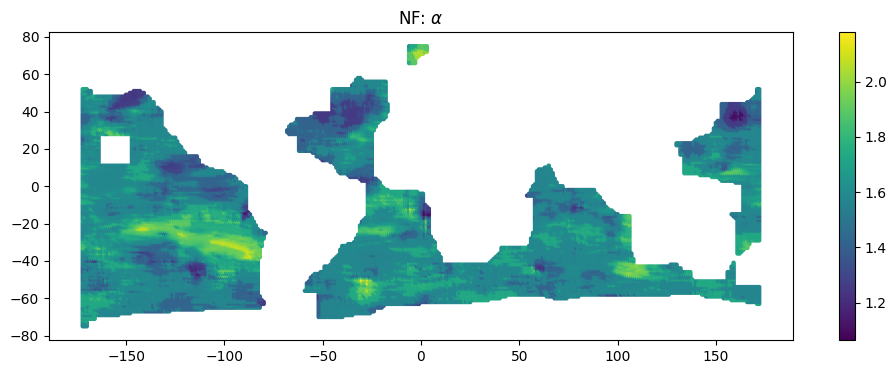

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df['x'], df['y'], c=df['alpha'], s=5,
            cmap='viridis', marker='o')
plt.colorbar()

plt.scatter(df[(df['alpha']<0)]['x'],
            df[(df['alpha']<0)]['y'],
            c='r', s=5, cmap='viridis', marker='o')
plt.title('NF: $\\alpha$');

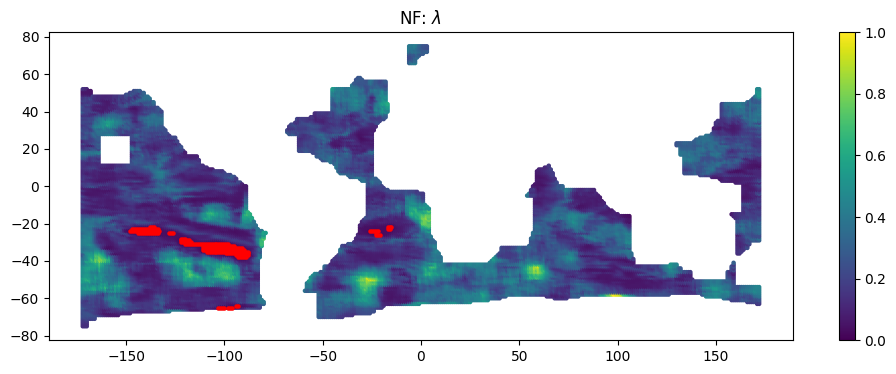

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df['x'], df['y'], c=df['ratio'], s=5,
            cmap='viridis', marker='o')

plt.scatter(df[(df['ratio']<0)]['x'],
            df[(df['ratio']<0)]['y'],
            c='r', s=5, cmap='viridis', marker='o')
plt.title('NF: $\\lambda$')
plt.colorbar();

## ML

Functions used in `2_ML.ipynb`

In [ ]:
from scipy.linalg import cholesky as chol, cho_solve

def generar_grilla(sqrt_n):
    xx = np.linspace(1,sqrt_n,sqrt_n)
    X, Y = np.meshgrid(xx,xx)
    return np.column_stack((X.flatten(), Y.flatten())) #Ordenados de izq a der y de abajo hacia arriba

P = lambda alpha: np.array([[np.cos(alpha), np.sin(alpha)],[-np.sin(alpha), np.cos(alpha)]])
D = lambda ratio: np.diag([1,ratio])
A = lambda alpha, ratio: P(alpha) @ D(ratio) @ P(alpha).T

matern_model = lambda t, x: (1 + x/t) * np.exp(-x/t) # nu=3/2

def cholesky(alpha, t, ratio, H):
    sqrt_H_TAH = np.sqrt(np.einsum('ijk,ijk->ij', H @ A(alpha, ratio) , H))
    sigma = matern_model(t, sqrt_H_TAH)
    return chol(sigma, lower=True, overwrite_a=True) # np.linalg.cholesky(sigma)

def ML(alpha, t, ratio, H, Z):
    L = cholesky(alpha, t, ratio, H)
    log_det_cov = 2 * np.sum(np.log(np.diag(L)))
    temp = cho_solve((L, True), Z)
    return -0.5 * (log_det_cov + np.dot(Z, temp))

from scipy.optimize import minimize

def negative_log_likelihood(params, H, Z):
    alpha, t, ratio = params
    return -ML(alpha, t, ratio, H, Z)

initial_guess = [np.deg2rad((0+180)/2), (0.02+5)/2, (0+1)/2]
tol = 1e-3
bounds = [(0, np.pi-tol), (0.0+tol, np.inf), (0.0+tol, 1.0)]

In [ ]:
%%time
results_ML = []
for x, y in factibles:
  points = ventana(x, y)[['x','y']].values
  Z = ventana(x, y)['z'].values
  Z = (Z-Z.mean())/Z.std()
  H = points[:, np.newaxis, :] - points[np.newaxis, :, :]
  y_ML = minimize(negative_log_likelihood, initial_guess, args=(H, Z), bounds=bounds, method='L-BFGS-B').x
  results_ML.append(list(y_ML))

CPU times: user 5h 6min 37s, sys: 40.5 s, total: 5h 7min 17s
Wall time: 3h 7min 30s


In [ ]:
results_ML = np.array(results_ML)

df_aux = pd.DataFrame(np.concatenate([factibles, results_ML], axis=1))
df_aux.columns = ['x', 'y', 'alpha', 'theta', 'ratio']
df_aux['Method'] = 'ML'

df = pd.concat([df, df_aux], axis=0)
df.head()

x     y     alpha     theta     ratio Method
0 -172.0 -75.0  1.582205  1.403904  0.091054     NF
1 -172.0 -74.0  1.583251  1.527794  0.098911     NF
2 -172.0 -73.0  1.586350  1.572304  0.106467     NF
3 -172.0 -72.0  1.725402  1.671025  0.121979     NF
4 -172.0 -71.0  1.627009  1.844938  0.137364     NF

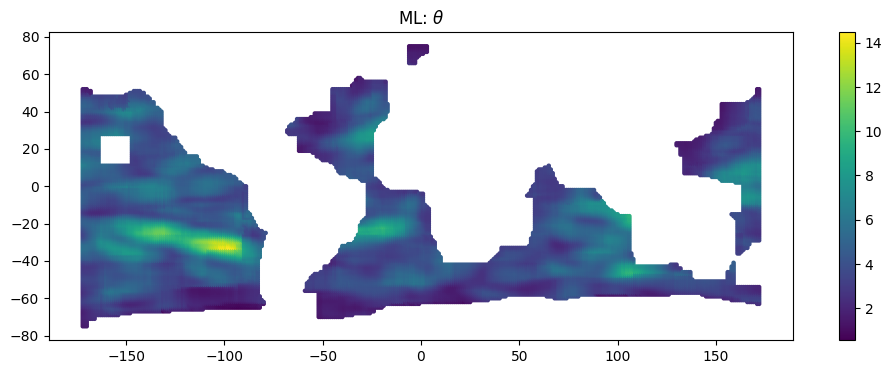

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df_aux['x'], df_aux['y'], c=df_aux['theta'], s=5,
            cmap='viridis', marker='o')#, vmax=5)
plt.colorbar()

plt.title('ML: $\\theta$');

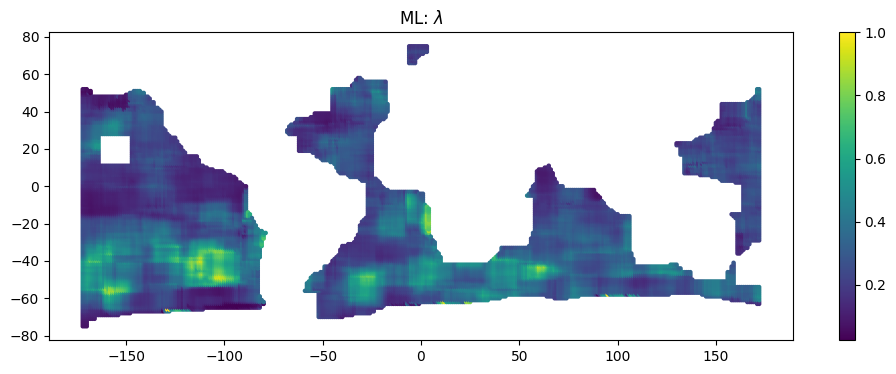

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df_aux['x'], df_aux['y'], c=df_aux['ratio'], s=5,
            cmap='viridis', marker='o')
plt.colorbar()

plt.title('ML: $\\lambda$');

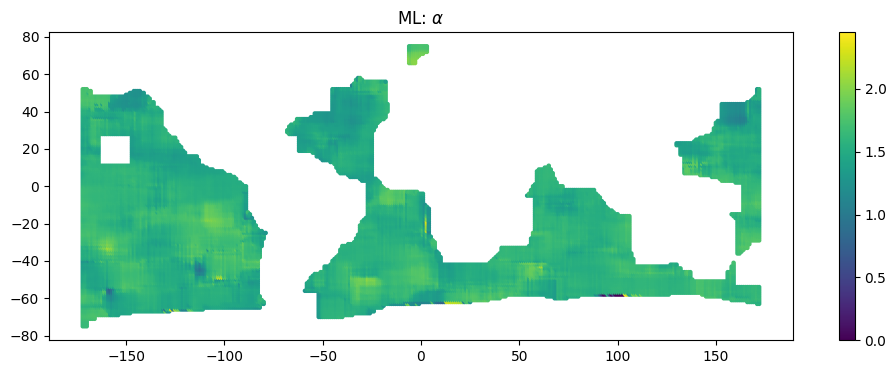

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df_aux['x'], df_aux['y'], c=df_aux['alpha'], s=5,
            cmap='viridis', marker='o')
plt.colorbar()

plt.title('ML: $\\alpha$');

## NV

We generated variogram maps with `1_gen_variogram_maps.R` in 159 s

In [ ]:
variograms = np.load(path + 'aplicacion/fields_sst_vario.npy')

In [ ]:
%%time
results_NV = y_scaler.inverse_transform(NV.predict(variograms, verbose = 0))

CPU times: user 6.63 s, sys: 206 ms, total: 6.84 s
Wall time: 10.8 s


In [ ]:
df_aux = pd.DataFrame(np.concatenate([factibles, results_NV], axis=1))
df_aux.columns = ['x', 'y', 'alpha', 'theta', 'ratio']
df_aux['Method'] = 'NV'

df = pd.concat([df, df_aux], axis=0)
df.head()

x     y     alpha     theta     ratio Method
0 -172.0 -75.0  1.582205  1.403904  0.091054     NF
1 -172.0 -74.0  1.583251  1.527794  0.098911     NF
2 -172.0 -73.0  1.586350  1.572304  0.106467     NF
3 -172.0 -72.0  1.725402  1.671025  0.121979     NF
4 -172.0 -71.0  1.627009  1.844938  0.137364     NF

Estimates falling outside the parameter space

In [ ]:
df_aux[(df_aux['alpha']<0) | (df_aux['theta']<0) | (df_aux['ratio']<0)]

x     y     alpha     theta     ratio Method
7165 -100.0 -64.0  1.375595  0.691223 -0.026262     NV
7238  -99.0 -64.0  1.376289  0.705419 -0.044661     NV
7310  -98.0 -64.0  1.376028  0.673936 -0.032716     NV
7382  -97.0 -64.0  1.380834  0.662354 -0.026641     NV
7454  -96.0 -64.0  1.393030  0.654951 -0.016788     NV
7525  -95.0 -64.0  1.409775  0.656193 -0.002449     NV

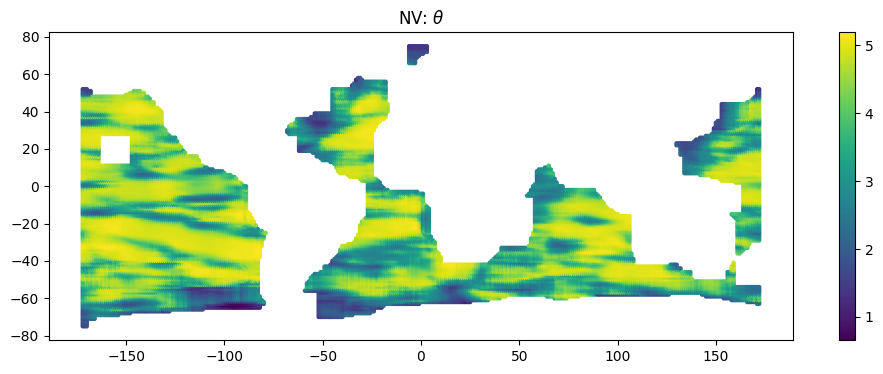

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df_aux['x'], df_aux['y'], c=df_aux['theta'], s=5,
            cmap='viridis', marker='o')
plt.colorbar()

plt.title('NV: $\\theta$');

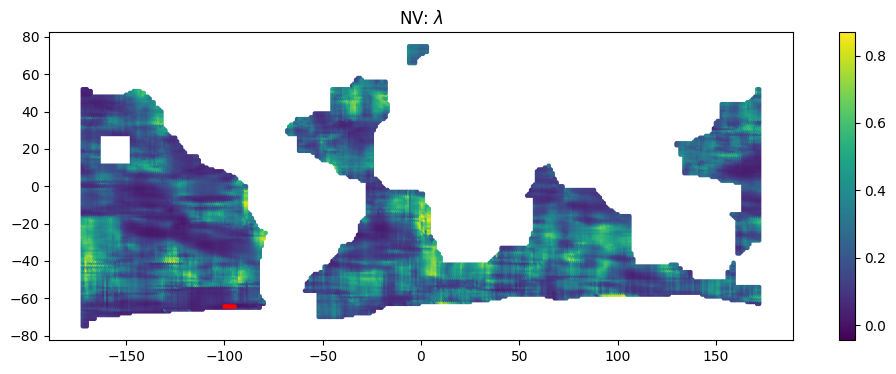

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df_aux['x'], df_aux['y'], c=df_aux['ratio'], s=5,
            cmap='viridis', marker='o')
plt.colorbar()
plt.scatter(df_aux[(df_aux['ratio']<0)]['x'],
            df_aux[(df_aux['ratio']<0)]['y'],
            c='r', s=5, cmap='viridis', marker='o')
plt.title('NV: $\\lambda$');

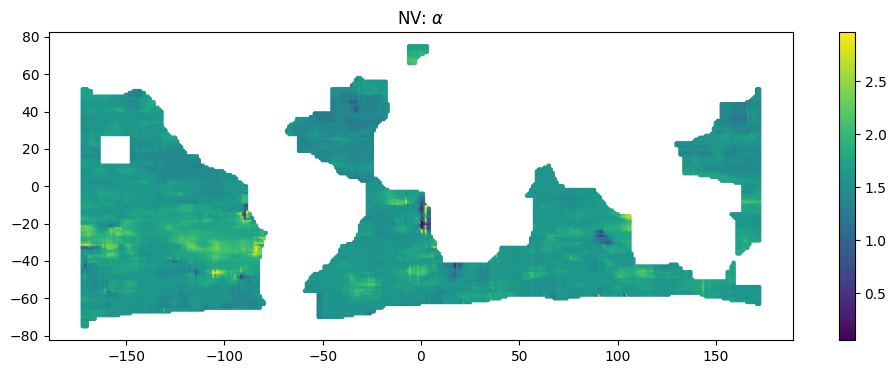

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(df_aux['x'], df_aux['y'], c=df_aux['alpha'], s=5,
            cmap='viridis', marker='o')
plt.colorbar()

plt.title('NV: $\\alpha$');

Save results

In [ ]:
df.to_csv(path+'aplicacion/results_sst.csv', sep=';', index=False)

## Comparison of methods

In [ ]:
df = pd.read_csv(path+'aplicacion/results_sst.csv', sep=';')
df.head()

x     y     alpha     theta    lambda Method
0 -172.0 -75.0  1.582205  1.403904  0.091054     NF
1 -172.0 -74.0  1.583251  1.527794  0.098911     NF
2 -172.0 -73.0  1.586350  1.572304  0.106467     NF
3 -172.0 -72.0  1.725402  1.671025  0.121979     NF
4 -172.0 -71.0  1.627009  1.844938  0.137364     NF

In [ ]:
groups = df.groupby('Method')

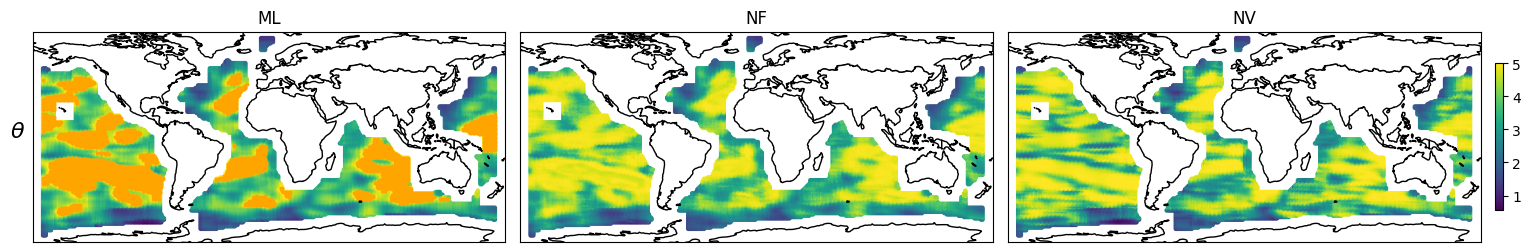

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, group) in enumerate(groups):
  sc = axs[idx].scatter(group['x'], group['y'], c=group['theta'], s=5,
                        cmap='viridis', marker='o',
                        vmin=df['theta'].min(), vmax=5)
  if name == 'ML':
    axs[idx].scatter(group[(group['theta']>5)]['x'],
                     group[(group['theta']>5)]['y'],
                     c='orange', s=3, marker='o')
  axs[idx].set_title(f'{name}')
  axs[idx].set_xlim(-180, 180); axs[idx].set_ylim(-80, 80)
  axs[idx].set_xticks([]); axs[idx].set_yticks([])
  world.plot(ax=axs[idx], color='white', edgecolor='black')

fig.text(-0.0, 0.5, f'$\\theta$', ha='center', fontsize=16)
fig.tight_layout()
fig.colorbar(sc, ax=axs.flatten(), orientation='vertical', fraction=0.005, pad=0.01)
fig.savefig(path+'Figures/sst_theta.png', dpi=150, bbox_inches='tight')
plt.show()

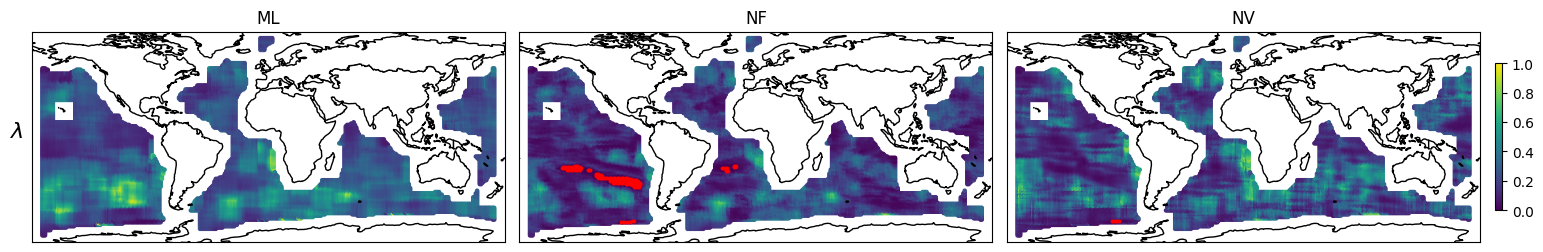

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, group) in enumerate(groups):
  sc = axs[idx].scatter(group['x'], group['y'], c=group['lambda'], s=5,
                        cmap='viridis', marker='o', vmin=0, vmax=1)
  axs[idx].set_title(f'{name}')
  axs[idx].scatter(group[(group['lambda']<0)]['x'],
                   group[(group['lambda']<0)]['y'],
                   c='r', s=3, marker='o')
  axs[idx].set_xlim(-180, 180); axs[idx].set_ylim(-80, 80)
  axs[idx].set_xticks([]); axs[idx].set_yticks([])
  world.plot(ax=axs[idx], color='white', edgecolor='black')

fig.text(-0.0, 0.5, f'$\\lambda$', ha='center', fontsize=16)
fig.tight_layout()
fig.colorbar(sc, ax=axs.flatten(), orientation='vertical', fraction=0.005, pad=0.01)
fig.savefig(path+'Figures/sst_lambda.png', dpi=150, bbox_inches='tight')
plt.show()

(390, 6)
(390, 6)
(390, 6)


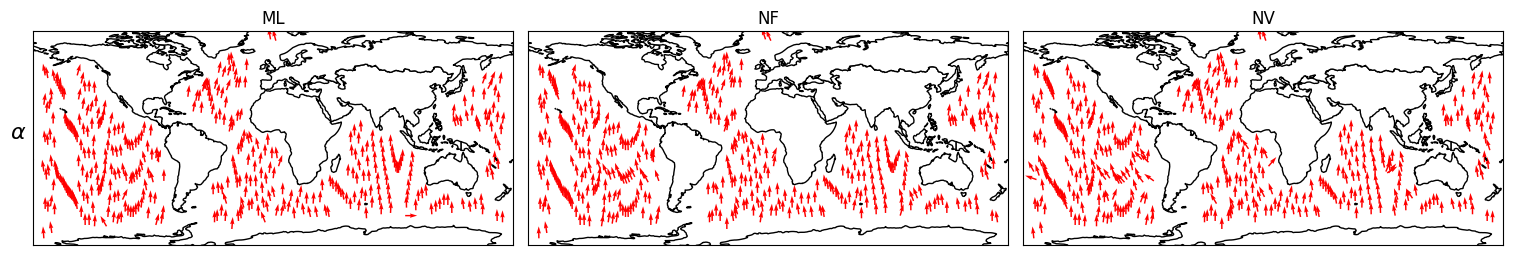

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, group) in enumerate(groups):
  group = group[(group['x']<=1000)].iloc[::50]
  print(group.shape)
  axs[idx].set_title(f'{name}')
  U = np.cos(group['alpha'])
  V = np.sin(group['alpha'])
  axs[idx].quiver(group['x'], group['y'], U, V, scale=40, color='red', headwidth=3)
  axs[idx].set_xlim(-180, 180); axs[idx].set_ylim(-80, 80)
  axs[idx].set_xticks([]); axs[idx].set_yticks([])
  world.plot(ax=axs[idx], color='white', edgecolor='black')

fig.text(0, 0.5, f'$\\alpha$', ha='center', fontsize=16)
fig.tight_layout()
fig.savefig(path+'Figures/sst_alpha.png', dpi=150, bbox_inches='tight')
plt.show()

(390, 6)
(390, 6)
(390, 6)


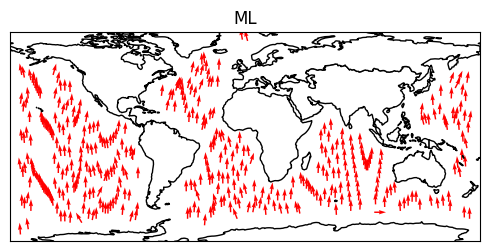

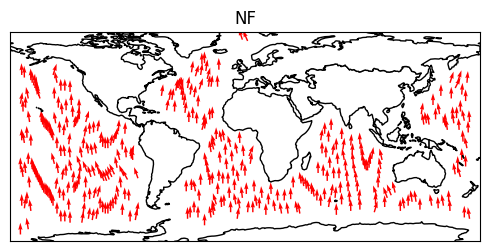

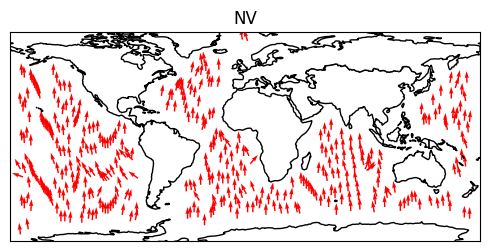

In [ ]:
for idx, (name, group) in enumerate(groups, 1):
  group = group[(group['x']<=1000)].iloc[::50]
  print(group.shape)

  fig, ax = plt.subplots(figsize=(5, 4))

  ax.set_title(f'{name}')
  U = np.cos(group['alpha'])
  V = np.sin(group['alpha'])
  ax.quiver(group['x'], group['y'], U, V, scale=40, color='red', headwidth=3)
  ax.set_xlim(-180, 180); ax.set_ylim(-80, 80)
  ax.set_xticks([]); ax.set_yticks([])
  world.plot(ax=ax, color='white', edgecolor='black')
  fig.tight_layout()
  fig.savefig(path+f'Figures/sst_alpha{idx}.png', dpi=150, bbox_inches='tight')

### Extra

In [ ]:
g_NF = groups.get_group('NF').reset_index(drop=True).drop(columns=['Method'])
g_NV = groups.get_group('NV').reset_index(drop=True).drop(columns=['Method'])
g_ML = groups.get_group('ML').reset_index(drop=True).drop(columns=['Method'])

In [ ]:
g_ML.loc[g_ML['theta']>5, 'theta']=np.nan

g_ML_NF = g_ML.copy()
g_ML_NF.loc[:, ['alpha', 'theta', 'lambda']] -= g_NF.loc[:, ['alpha', 'theta', 'lambda']]

g_ML_NV = g_ML.copy()
g_ML_NV.loc[:, ['alpha', 'theta', 'lambda']] -= g_NV.loc[:, ['alpha', 'theta', 'lambda']]

In [ ]:
import matplotlib.colors as mcolors

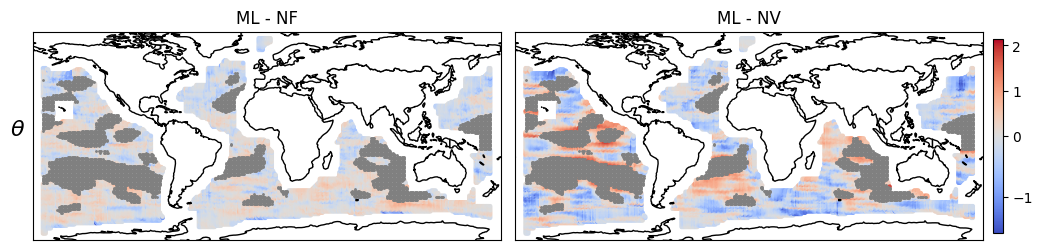

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
norm = mcolors.TwoSlopeNorm(vmin=min(g_ML_NF['theta'].min(), g_ML_NV['theta'].min()),
                            vmax=max(g_ML_NF['theta'].max(), g_ML_NV['theta'].max()),
                            vcenter=0)
for ax, group, title in zip(axs.flatten(), [g_ML_NF, g_ML_NV], ['ML - NF', 'ML - NV']):
  sc = ax.scatter(group['x'], group['y'], c=group['theta'], s=5, cmap='coolwarm', norm=norm, marker='o')
  world.plot(ax=ax, color='white', edgecolor='black')
  ax.scatter(group[(group['theta'].isnull())]['x'],
            group[(group['theta'].isnull())]['y'],
            c='gray', s=1)
  ax.set_xlim(-180, 180); ax.set_ylim(-80, 80)
  ax.set_xticks([]); ax.set_yticks([])
  ax.set_title(f'{title}')

fig.text(0, 0.5, f'$\\theta$', ha='center', fontsize=16)
fig.tight_layout()
fig.colorbar(sc, ax=axs.flatten(), orientation='vertical', fraction=0.01, pad=0.01)
fig.savefig(path+'Figures/sst_diff_theta.png', dpi=150, bbox_inches='tight')
plt.show()

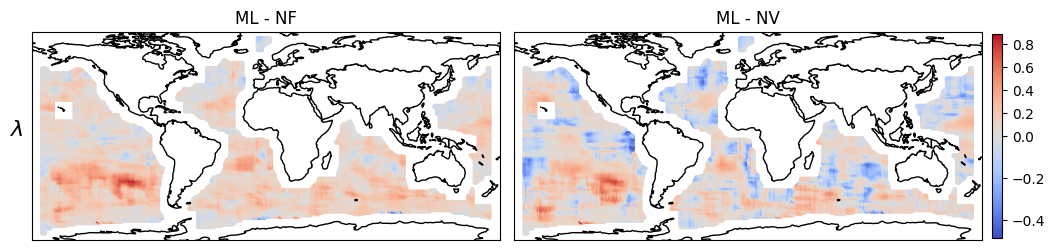

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
norm = mcolors.TwoSlopeNorm(vmin=min(g_ML_NF['lambda'].min(), g_ML_NV['lambda'].min()),
                            vmax=max(g_ML_NF['lambda'].max(), g_ML_NV['lambda'].max()),
                            vcenter=0)
for ax, group, title in zip(axs.flatten(), [g_ML_NF, g_ML_NV], ['ML - NF', 'ML - NV']):
  sc = ax.scatter(group['x'], group['y'], c=group['lambda'], s=5, cmap='coolwarm', norm=norm, marker='o')
  world.plot(ax=ax, color='white', edgecolor='black')
  ax.set_xlim(-180, 180); ax.set_ylim(-80, 80)
  ax.set_xticks([]); ax.set_yticks([])
  ax.set_title(f'{title}')

fig.text(0, 0.5, f'$\\lambda$', ha='center', fontsize=16)
fig.tight_layout()
fig.colorbar(sc, ax=axs.flatten(), orientation='vertical', fraction=0.0105, pad=0.01)
fig.savefig(path+'Figures/sst_diff_lambda.png', dpi=150, bbox_inches='tight')
plt.show()

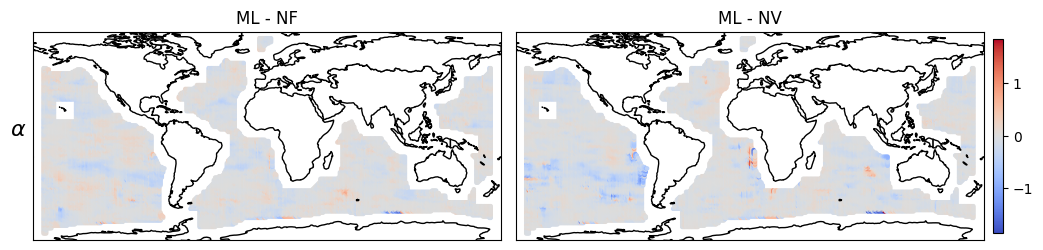

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
norm = mcolors.TwoSlopeNorm(vmin=min(g_ML_NF['alpha'].min(), g_ML_NV['alpha'].min()),
                            vmax=max(g_ML_NF['alpha'].max(), g_ML_NV['alpha'].max()),
                            vcenter=0)
for ax, group, title in zip(axs.flatten(), [g_ML_NF, g_ML_NV], ['ML - NF', 'ML - NV']):
  sc = ax.scatter(group['x'], group['y'], c=group['alpha'], s=5, cmap='coolwarm', norm=norm, marker='o')
  world.plot(ax=ax, color='white', edgecolor='black')
  ax.set_xlim(-180, 180); ax.set_ylim(-80, 80)
  ax.set_xticks([]); ax.set_yticks([])
  ax.set_title(f'{title}')

fig.text(0, 0.5, f'$\\alpha$', ha='center', fontsize=16)
fig.tight_layout()
fig.colorbar(sc, ax=axs.flatten(), orientation='vertical', fraction=0.01, pad=0.01)
fig.savefig(path+'Figures/sst_diff_alpha.png', dpi=150, bbox_inches='tight')
plt.show()

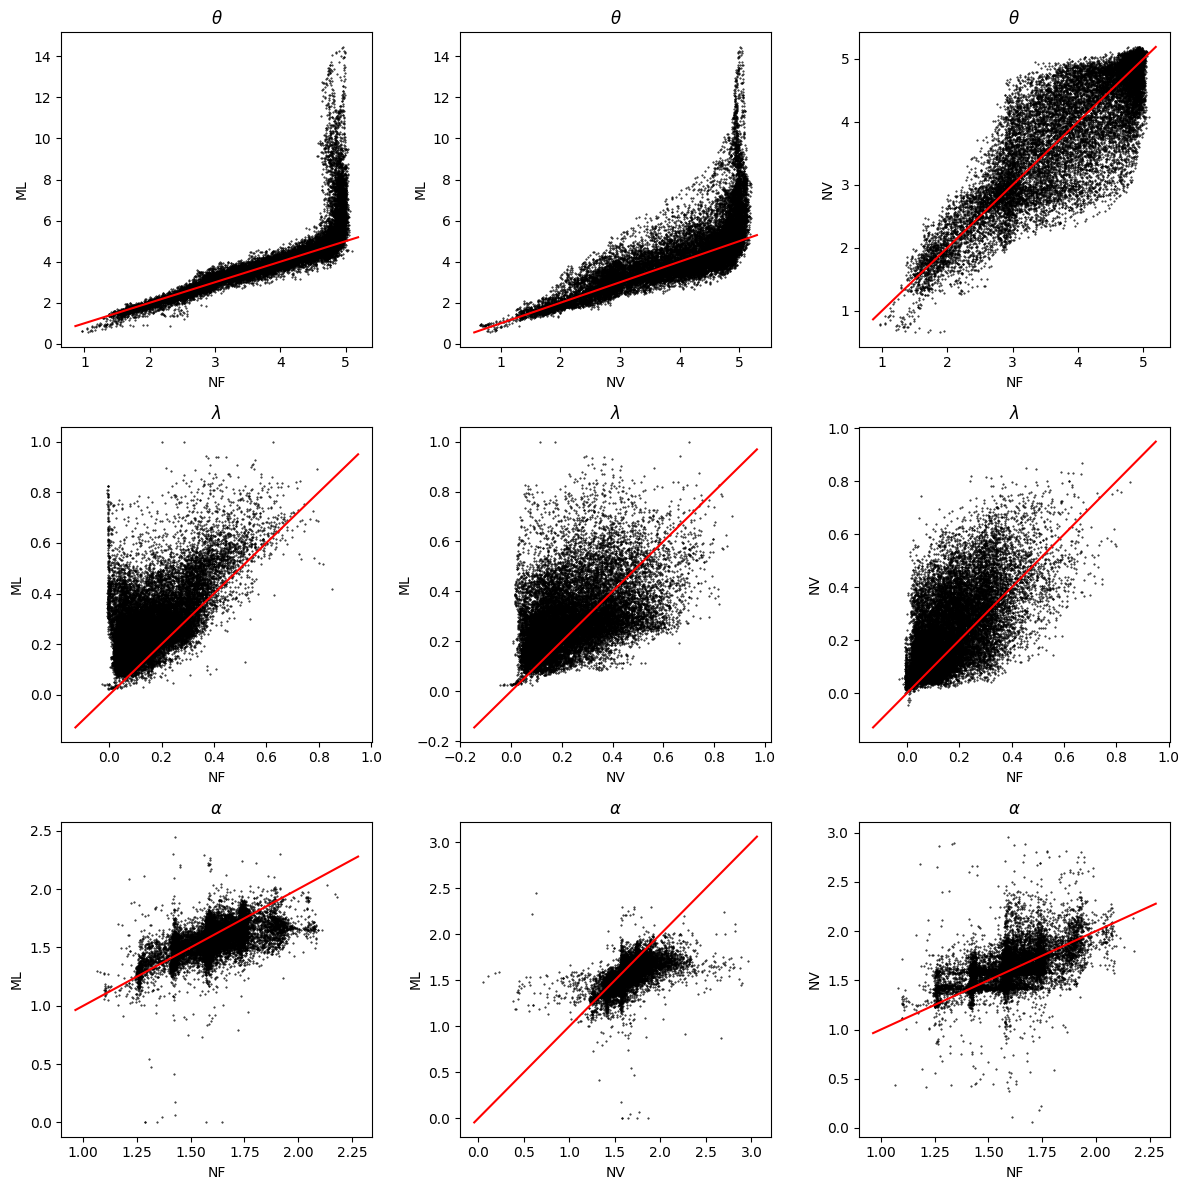

In [ ]:
g_NF = groups.get_group('NF').reset_index(drop=True).drop(columns=['Method'])
g_NV = groups.get_group('NV').reset_index(drop=True).drop(columns=['Method'])
g_ML = groups.get_group('ML').reset_index(drop=True).drop(columns=['Method'])

fig, axs = plt.subplots(3, 3, figsize=(12,12))

def comparativa(df_1, df_2, name_1, name_2, var, ax):
  ax.scatter(df_1[var], df_2[var], s=0.2, marker='o', c='k')
  ax.set_title(f'$\\{var}$')
  ax.set_xlabel(f'{name_1}'); ax.set_ylabel(f'{name_2}')
  ax.plot([df_1[var].min()-0.1, df_1[var].max()+.1],
          [df_1[var].min()-0.1, df_1[var].max()+.1], c='r');

comparativa(g_NF, g_ML, 'NF', 'ML', 'theta', axs[0,0])
comparativa(g_NV, g_ML, 'NV', 'ML', 'theta', axs[0,1])
comparativa(g_NF, g_NV, 'NF', 'NV', 'theta', axs[0,2])

comparativa(g_NF, g_ML, 'NF', 'ML', 'lambda', axs[1,0])
comparativa(g_NV, g_ML, 'NV', 'ML', 'lambda', axs[1,1])
comparativa(g_NF, g_NV, 'NF', 'NV', 'lambda', axs[1,2])

comparativa(g_NF, g_ML, 'NF', 'ML', 'alpha', axs[2,0])
comparativa(g_NV, g_ML, 'NV', 'ML', 'alpha', axs[2,1])
comparativa(g_NF, g_NV, 'NF', 'NV', 'alpha', axs[2,2])

fig.tight_layout()